In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import daspi as dsp
import numpy as np
import pandas as pd
import matplotlib as mpl

from scipy import stats
from typing import Any
from typing import Dict
DPI = 120
dsp.STR._username_ = 'j4ggr'
dsp.__version__

'1.4.3'

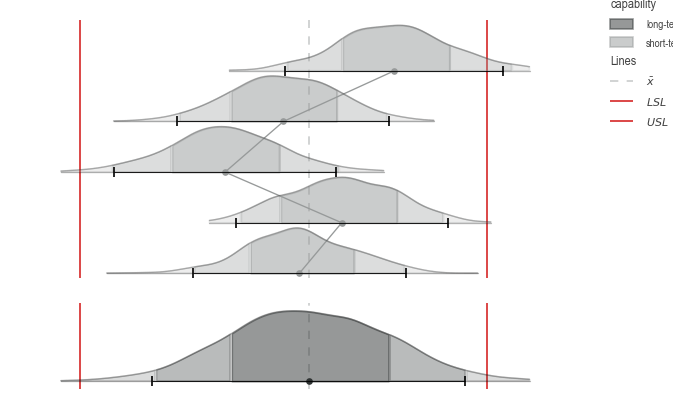

In [2]:
np.random.seed(3)
N_SAMPLES = 500
HEIGHT = 0.9
means = np.random.random(5)-0.5
df_batch = pd.DataFrame()

for i, mean in enumerate(means):
    pos = i
    data = pd.DataFrame({
        'capability': 'short-term',
        'position': pos,
        'values': stats.norm.rvs(size=N_SAMPLES, loc=mean, scale=0.2)})
    df_batch = pd.concat([df_batch, data], axis=0, ignore_index=True)
df_tot = pd.DataFrame({
    'capability': 'long-term',
    'position': 0,
    'mean': '0',
    'values': df_batch['values']})

chart = dsp.JointChart(
        source=pd.concat([df_batch, df_tot]),
        target='values',
        feature='position',
        hue='capability',
        ncols=1,
        nrows=2,
        height_ratios=[3, 1],
        target_on_y=False,
        sharex=True,
        sharey=False,
        colors=(dsp.DEFAULT.PLOTTING_COLOR, '#979A9A')
    ).stripes(
        stripes=[dsp.StripeLine(
            r'\bar x', df_tot['values'].mean(), orientation='vertical')],
        spec_limits=dsp.SpecLimits(-0.75, 0.75),
    ).label(
    )

hueing = chart.charts[0].hueing

def axes_settings(ax) -> None:
    ax.xaxis.set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set(ylim=(-0.1, None), xlim=(-1, 1))

kw_base: Dict[str, Any] = dict(
    feature='position',
    target='values',
    target_on_y=False,
    ax=chart.axes[0, 0],
    color=hueing.categories[1])
kw_kde: Dict[str, Any] = dict(
    height=HEIGHT,
    fill=True,
    ignore_feature=False)
kw_spread: Dict[str, Any] = dict(
    marker='o',
    agreement=4,
)
dsp.CenterLocation(source=df_batch, show_center=False, **kw_base)()
for pos, group in df_batch.groupby('position'):
    dsp.GaussianKDE(source=group, f_base=pos, **(kw_base | kw_kde))()
    dsp.SpreadWidth(source=group, **(kw_base | kw_spread))()

kw_base['ax'] = chart.axes[1, 0]
kw_base['color'] = hueing.categories[0]
dsp.GaussianKDE(source=df_tot, f_base=0, **(kw_base | kw_kde))()
dsp.SpreadWidth(source=df_tot, **(kw_base | kw_spread))()

for ax in chart.axes.flat:
    axes_settings(ax)

In [3]:
pos, data = next(iter(df_batch.groupby('position')))
estimation = dsp.ProcessEstimator(data['values'], dsp.SpecLimits(-0.75, 0.75))
estimation.Z_lt

2.0395762631892227

In [4]:
estimation = dsp.ProcessEstimator(df_tot['values'], dsp.SpecLimits(-0.75, 0.75))
estimation.Z

2.281028062704287

,parallel,perpendicular
n_samples,20,20
n_missing,0,0
n_ok,18,20
n_nok,2,0
n_errors,0,0
ok,90.00 %,100.00 %
nok,10.00 %,0.00 %
nok_norm,8.01 %,3.73 %
nok_fit,7.24 %,5.77 %
min,8.5,17.5


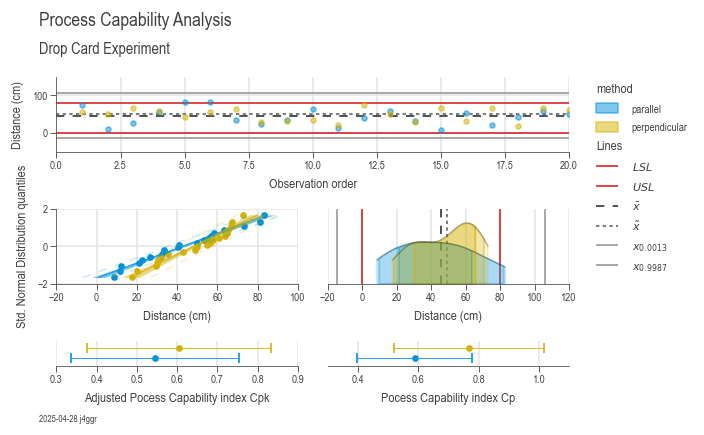

In [5]:
import daspi as dsp

df = dsp.load_dataset('drop_card')
spec_limits = dsp.SpecLimits(0, float(df.loc[0, 'usl']))
target = 'distance'

chart = dsp.ProcessCapabilityAnalysisCharts(
        source=df,
        target=target,
        spec_limits=spec_limits,
        hue='method'
    ).plot(
    ).stripes(
    ).label(
        fig_title='Process Capability Analysis',
        sub_title='Drop Card Experiment',
        target_label='Distance (cm)',
        info=True
    )

chart.save('./docs/img/cpk-analysis_drop-card.png', dpi=DPI)

samples_parallel = df[df['method']=='parallel'][target]
samples_series = df[df['method']=='perpendicular'][target]

pd.concat([
    dsp.ProcessEstimator(samples_parallel, spec_limits).describe(),
    dsp.ProcessEstimator(samples_series, spec_limits).describe()],
    axis=1,
    ignore_index=True,
).rename(
    columns={0: 'parallel', 1: 'perpendicular'}
)


ASS temperature: logistic
Godamed temperature: gamma
ASS dissolution: foldnorm
Godamed dissolution: norm


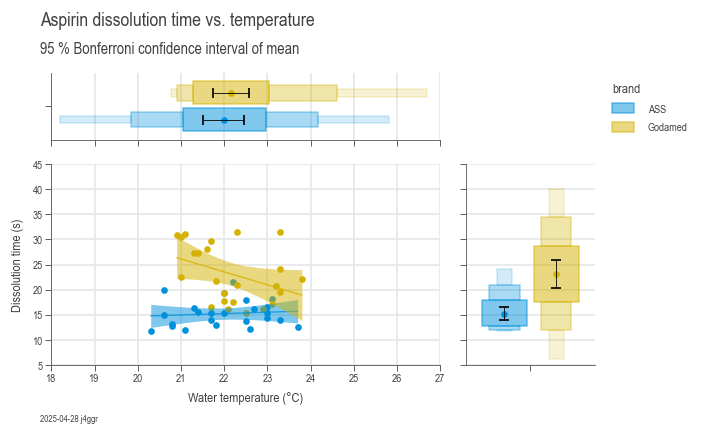

In [6]:
import daspi as dsp

df = dsp.load_dataset('aspirin-dissolution')
hue = 'brand'
n_groups = df.groupby(hue).ngroups
chart = dsp.BivariateUnivariateCharts(
        source=df,
        target='dissolution',
        feature='temperature',
        hue=hue,
        dodge_univariates=True,
    ).plot_univariates(
        dsp.MeanTest, n_groups=n_groups
    ).plot_univariates(
        dsp.QuantileBoxes, strategy='fit'
    ).plot_bivariate(
        dsp.LinearRegressionLine, show_fit_ci=True
    ).label(
        fig_title='Aspirin dissolution time vs. temperature',
        sub_title='95 % Bonferroni confidence interval of mean',
        feature_label='Water temperature (°C)',
        target_label='Dissolution time (s)',
        info=True
    )

brands = (brand for brand in df[hue].unique().tolist()*2)
for plot in chart.plots:
    if isinstance(plot, dsp.QuantileBoxes):
        print(f'{next(brands)} {plot.target}: {plot.estimation.dist.name}')

formula:
dissolution ~ 16.0792 + 2.3750*employee[T.B] + 0.8375*employee[T.C] + 10.7500*brand[T.Godamed] - 3.8000*water[T.tap] - 5.7167*brand[T.Godamed]:water[T.tap]

Model summary:
   hierarchical least_parameter   p_least         s         aic        r2  \
0          True        employee  0.023298  2.374693  224.835935  0.857379   

   r2_adj   r2_pred  
0  0.8404  0.813719  

Parameter statistics:
                                    coef   std err          t             p  \
Intercept                      16.079167  0.839581  19.151424  2.275979e-22   
employee[T.B]                   2.375000  0.839581   2.828793  7.132978e-03   
employee[T.C]                   0.837500  0.839581   0.997522  3.242240e-01   
brand[T.Godamed]               10.750000  0.969464  11.088598  4.695450e-14   
water[T.tap]                   -3.800000  0.969464  -3.919690  3.212100e-04   
brand[T.Godamed]:water[T.tap]  -5.716667  1.371030  -4.169616  1.493044e-04   

                                  ci_low     ci_upp  
Intercept                      14.384824  17.773509  
employee[T.B]                   0.680657   4.069343  
employee[T.C]                  -0.856843   2.531843  
brand[T.Godamed]                8.793542  12.706458  
water[T.tap]                   -5.756458  -1.843542  
brand[T.Godamed]:water[T.tap]  -8.483516  -2.949817  

Analysis of variance:
Typ-I        DF          SS          MS           F             p        n2
Source                                                                     
employee      2   46.431667   23.215833    4.116891  2.329817e-02  0.027960
brand         1  747.340833  747.340833  132.526821  1.424173e-14  0.450027
water         1  532.000833  532.000833   94.340328  2.657815e-12  0.320355
brand:water   1   98.040833   98.040833   17.385695  1.493044e-04  0.059037
Residual     42  236.845000    5.639167         NaN           NaN  0.142621

Variance inflation factor:
             DF  VIF      GVIF  Threshold  Collinear               Method
Intercept     1  5.0  2.236068   2.236068       True            R_squared
employee      2  1.0       1.0   1.495349      False          generalized
brand         1  1.0       1.0   2.236068      False            R_squared
water         1  1.0       1.0   2.236068      False            R_squared
brand:water   1  1.0       1.0   2.236068      False  single_order-2_term

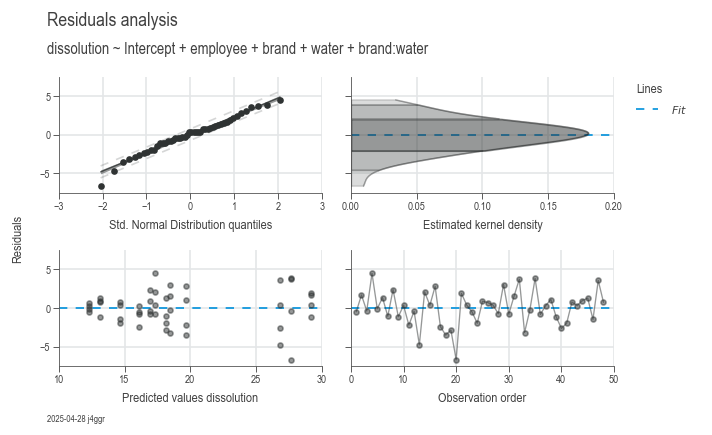

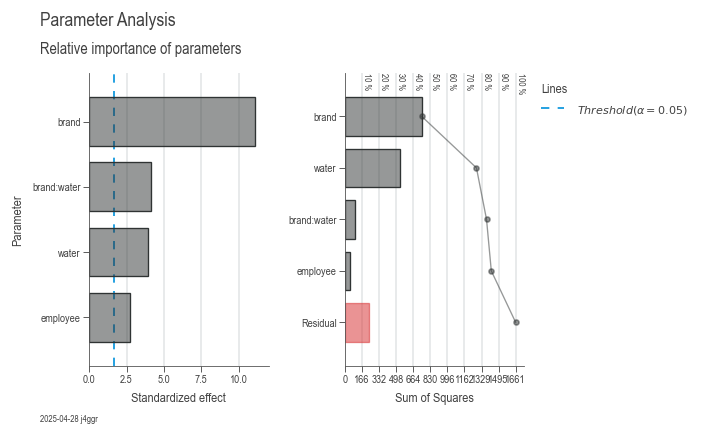

In [7]:
import daspi as dsp

df = dsp.load_dataset('aspirin-dissolution')
model = dsp.LinearModel(
    source=df,
    target='dissolution',
    features=['employee', 'stirrer', 'brand', 'catalyst', 'water'],
    disturbances=['temperature', 'preparation'],
    order=2)
df_gof = pd.DataFrame()
for data_gof in model.recursive_elimination():
    df_gof = pd.concat([df_gof, data_gof])

dsp.ResidualsCharts(model).plot().stripes().label(info=True).save('./docs/img/anova_dissolution_residues.png', dpi=DPI)
dsp.ParameterRelevanceCharts(model).plot().stripes().label(info=True).save('./docs/img/anova_dissolution_params.png', dpi=DPI)
model

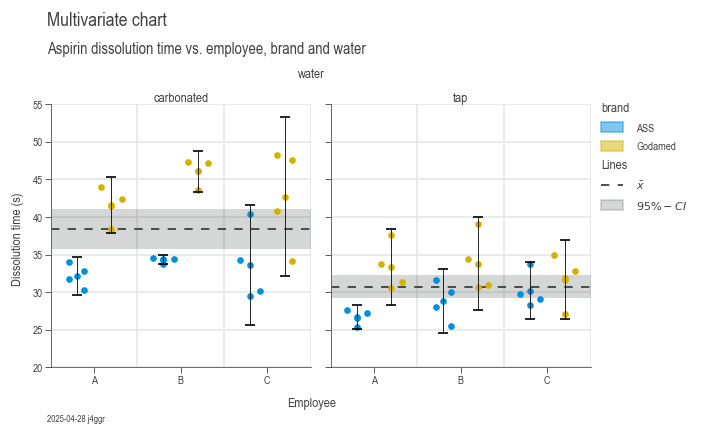

In [8]:
dsp.MultivariateChart(
        source=df,
        target='time',
        feature='employee',
        hue='brand',
        col='water',
        dodge=True
    ).plot(
        dsp.MeanTest, n_groups=1,
    ).plot(
        dsp.Beeswarm,
    ).stripes(
        mean=True,
        confidence=0.95
    ).label(
        fig_title='Multivariate chart',
        sub_title='Aspirin dissolution time vs. employee, brand and water',
        target_label='Dissolution time (s)',
        feature_label='Employee',
        info=True
    )